###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D axisymmetric spherical SH finite difference modelling  - Moon

In this lesson we compute the axisymmetric SH wave propagation of a deep moonquake event for an elastic lunar model. The resulting wavefields are compared with the modelling results of the earth PREM.

## The discovery and characterization of moonquakes

On 21st July 1969, the astronauts of Apollo 11 deployed the first passive seismometer on the moon. While it only delivered seismic data for 3 weeks, more advanced seismometers where setup during the Apollo 12, 14, 15 and 16 as part of the Apollo Lunar Surface Experiments Package [(ALSEP)](https://en.wikipedia.org/wiki/Apollo_Lunar_Surface_Experiments_Package) 

<img src="images/moon_apollo_seis.jpg" width="100%">

which operated perfectly from 1969 to 1977. The seismometers could be calibrated by the impact of the Saturn IVB booster rocket stage and lunar modules [(Latham et al. 1970)](http://science.sciencemag.org/content/170/3958/620.long). During the 8 years of operation, the seismometers recorded more than 12000 events, which can be classified according to their signal characteristics [(Khan et al. 2013)](http://jupiter.ethz.ch/~akhan/amir/Publications_files/tecto_moon13.pdf) as

- **Deep moonquakes**: These events occur in depths between 700 to 1200 km, are quite frequent and appear to come from a limited number of "nested" spatial hypocenters (~316) within a diameter of 1 km. The seismograms of quakes from the same focus are very similar to another. This allows the stacking of events from common source regions to improve the signal-to-noise ratio. Each focus region seems to become active at a fixed time in the lunar monthly cycle . These type of quakes thus show distinct periodicity with periods of both 14 and 206 days, which can be associated with terrestrial and solar tides ([Ewing et al. 1971](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/104F132A49158C1CF0E102BC968A7771/S1539299600000101a.pdf/seismology-of-the-moon-and-implications-on-internal-structure-origin-and-evolution.pdf), [Meissner et al. 1973](http://adsabs.harvard.edu/full/1973Moon....6..292M))

- **Shallow lunar quakes**: These events are relatively infrequent, have shallow foci (50 - 220 km depth), are the most energetic (magnitude 3 - 5) and quite sporadic with no discernible pattern in the position or time of occurrence. Compared to the deep moonquakes there is no correlation with the tidal cycles. A total of only 28 events were recorded over eight years (~ 3 - 4 per year). These events are like terrestrial intra-plate tectonic events.

- **Thermal events**: These are small local events in a depth between 1.5 - 4 km, that occur around sunrise and sunset with a periodicity of the lunar (synodic) month (29.5 days). A possible explanation of the thermal events is the significant temperature change after lunar sunrise at the terminator, leading to small-scale cracking of the near-surface [(Duennebier & Sutton 1974)](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/JB079i029p04351). 

- **Impact events**: The long period seismometers detected roughly 1700 events which could be related to the impact of meteoroids with masses between 0.1 to 50 kg or man-made objects. 9 artificial impacts on the lunar surface were generated in order to calibrate the seismometers. These were a combination of the Saturn third stage rockets and the ascent stages of the lunar modules. Because the masses of the objects and the exact times and velocities of their impacts were known, their impact energy could be calculated, and the travel times to the various seismometers accurately determined. The short period sensors detected many more impacts from smaller meteoroids.

## Global axisymmetric SH modelling of 1D lunar model

[Weber et al. (2011)](http://science.sciencemag.org/content/331/6015/309) reprocessed the Apollo network data by stacking deep seismic events to enhance the visibility of the reflected core phases. The derived core model combined with known crustal and mantle models will be the basis for our global axisymmetric SH modelling ...

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import interpolate

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

As usual, we first define the modelling parameters for an axisymmetric moon model ...

In [3]:
# Definition of modelling parameters
# ----------------------------------
rcore = 330 * 1000.0     # moon fluid core radius [m]
rplanet = 1736 * 1000.0  # moon radius [m]

nr = 400      # number of spatial gridpoints in r-direction
dr = (rplanet - rcore) / nr # spatial gridpoint distance in r-direction

# calculate dtheta based on dr
dtheta = dr / rcore
ntheta = (int) (np.pi / dtheta)  # number of spatial gridpoints in theta-direction
ntheta += 2

# Define PREM model filename
name_model = "moon_model/moon_weber2011.dat"

# Acquisition geometry
tmax = 1000.0           # maximum recording time of the seismogram (s)

isnap = 5  # snapshot interval (timesteps)

... next we read the 1D lunar model by [Weber et al. 2011](http://science.sciencemag.org/content/331/6015/309) ...

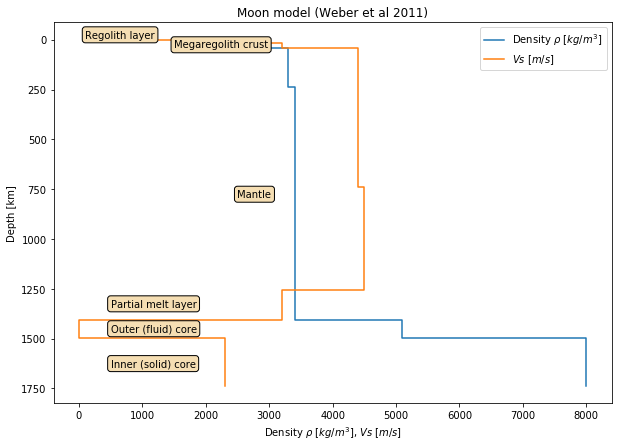

In [4]:
# Read and plot moon model
# ------------------------
model = np.loadtxt(name_model, delimiter='\t', skiprows=2)

radius = model[:,0] # radius [m]
rho1D = model[:,1]  # density [kg/m^3]
vs1D = model[:,3]   # S-wave velocity model [m/s]

# Define figure size
rcParams['figure.figsize'] = 10, 7

depth = radius[0] - radius

plt.plot(rho1D,depth/1000, label=r"Density $\rho$ [$kg/m^3$]")
plt.plot(vs1D,depth/1000, label=r"$Vs$ [$m/s$]")

# Annotate model
# --------------
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat')

# place a text box in upper left in axes coords
plt.text(100, -50, "Regolith layer", fontsize=10, verticalalignment='top', bbox=props)
plt.text(1500, 0, "Megaregolith crust", fontsize=10, verticalalignment='top', bbox=props)
plt.text(2500, 750, "Mantle", fontsize=10, verticalalignment='top', bbox=props)
plt.text(500, 1300, "Partial melt layer", fontsize=10, verticalalignment='top', bbox=props)
plt.text(500, 1425, "Outer (fluid) core", fontsize=10, verticalalignment='top', bbox=props)
plt.text(500, 1600, "Inner (solid) core", fontsize=10, verticalalignment='top', bbox=props)

plt.title("Moon model (Weber et al 2011)")
plt.ylabel("Depth [km]")
plt.xlabel(r"Density $\rho$ [$kg/m^3$], $Vs$ [$m/s$]")
plt.gca().invert_yaxis()
plt.legend()

plt.show()

The model consists of a regolith layer, crust, mantle, partially melted layer, outer (fluid) and inner (solid) core.

### Moon model without regolith layer

The S-wave velocity within the regolith layer is very low ($Vs = 500\; m/s$), which would require a very fine spatial model discretization and therefore more computation time. To decrease computational costs, we increase the S-wave velocity within the regolith layer to $Vs = 1800\; m/s$:

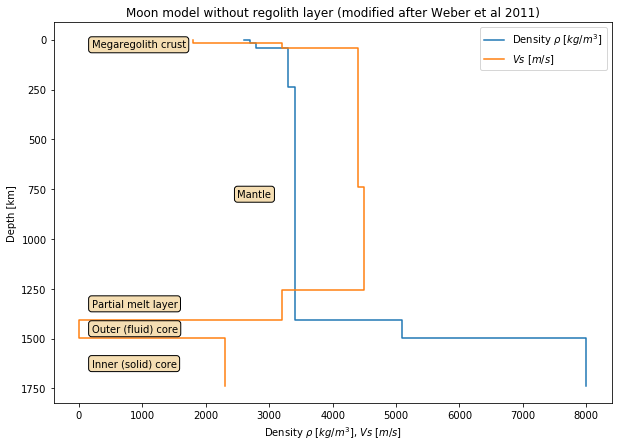

In [5]:
# Remove regoltih layer from moon model
# -------------------------------------
vs1D[0:2] = 1800 # remove regolith layer from S-wave velocity model [m/s]

plt.plot(rho1D,depth/1000, label=r"Density $\rho$ [$kg/m^3$]")
plt.plot(vs1D,depth/1000, label=r"$Vs$ [$m/s$]")

# Annotate model
# --------------
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat')

# place a text box in upper left in axes coords
plt.text(200, 0, "Megaregolith crust", fontsize=10, verticalalignment='top', bbox=props)
plt.text(2500, 750, "Mantle", fontsize=10, verticalalignment='top', bbox=props)
plt.text(200, 1300, "Partial melt layer", fontsize=10, verticalalignment='top', bbox=props)
plt.text(200, 1425, "Outer (fluid) core", fontsize=10, verticalalignment='top', bbox=props)
plt.text(200, 1600, "Inner (solid) core", fontsize=10, verticalalignment='top', bbox=props)

plt.title("Moon model without regolith layer (modified after Weber et al 2011)")
plt.ylabel("Depth [km]")
plt.xlabel(r"Density $\rho$ [$kg/m^3$], $Vs$ [$m/s$]")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Based on the spatial model discretization defined above, we calculate the centre frequency of the source wavelet, assuming $N_\lambda=12$ gridpoints per dominant wavelength.

In [6]:
# Calculate dominant frequency of the source wavelet
# --------------------------------------------------
Nlam = 12                     # number of grid points per dominant wavelength
vsmin = vs1D[0]               # minimum S-wave velocity [m/s]
f0 = vsmin / (Nlam * dr)      # centre frequency of the source wavelet [Hz]
print('f0 = ', f0, ' Hz')
print('Period T = ', 1/f0, ' s')
t0   = 4. / f0                # source time shift (s)

f0 =  0.04267425320056899  Hz
Period T =  23.433333333333334  s


The dominant period of 23 s for moonquakes is unrealistic low, but due the limited computational  resources of your laptop we will use this very low-frequency source wavelet.

For the axisymmetric SH modelling, we use the same FD code as for the earth PREM modelling. First, we define the particle velocity $v_\phi$ update ...

In [7]:
# Particle velocity vphi update
# ---------------------------
@jit(nopython=True) # use JIT for C-performance
def update_vel(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, rho, r, theta):
    
    # 2nd order FD operator   
    for i in range(1, ntheta - 1):
        for j in range(1, nr - 1):

            # Calculate spatial derivatives  (2nd order operator)           
            srp_r = (srp[i,j] - srp[i,j-1]) / dr
            stp_t = (stp[i,j] - stp[i-1,j]) / (r[j] * dtheta)            

            # Average stress wavefields at point (i,j)
            vphi_avg = (((srp[i,j] + srp[i,j-1]) / 2) * 3 + 
                         (stp[i,j] + stp[i-1,j]) / np.tan(theta[i])
                       ) / r[j]
            
            # Update particle velocities vphi
            vphi[i,j] = vphi[i,j] + (dt/rho[i,j]) * (srp_r + stp_t + vphi_avg)                               
                
    return vphi

... then update the shear stress components $\sigma_{r\phi}$ and $\sigma_{\theta\phi}$ ...

In [8]:
# Shear stress srp, stp updates
# -----------------------------
@jit(nopython=True) # use JIT for C-performance
def update_stress(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, mur, mutheta, thetah, r, rh):
    
    # 2nd order FD operator
    for i in range(1, ntheta - 1):
        for j in range(1, nr - 1):

            # Calculate spatial derivatives (2nd order operator)
            vphi_r = (vphi[i,j + 1] - vphi[i,j]) / dr
            vphi_theta = (vphi[i + 1,j] - vphi[i,j]) / (dtheta * r[j])

            # calculate vphi at (i,j+1/2)
            vphih = (vphi[i,j + 1] + vphi[i,j]) / (2 * rh[j])
            
            # calculate vphi at (i+1/2,j)
            vphithetah = (vphi[i + 1,j] + vphi[i,j]) / (2 * r[j] * np.tan(thetah[i]))
            
            # Update shear stresses
            srp[i,j] = srp[i,j] + dt * mur[i,j] * (vphi_r - vphih)
            stp[i,j] = stp[i,j] + dt * mutheta[i,j] * (vphi_theta - vphithetah)                    
    
    return srp, stp

... and averaging the shear modulus, where I additionally checked if the shear modulus is not equal 0 to avoid further trouble during the FD modelling ...

In [9]:
# Harmonic averages of shear modulus
# ----------------------------------
@jit(nopython=True) # use JIT for C-performance
def shear_avg(mu, nr, ntheta, mur, mutheta):
    
    for i in range(1, ntheta - 1):
        for j in range(1, nr - 1):
            
            # Calculate harmonic averages of shear moduli                                
            
            # Check if mu=0 on the FD grid
            if(mu[i+1,j]<1e-20 or mu[i,j]<1e-20):
                mutheta[i,j] = 0.0
            else:
                mutheta[i,j] = 2 / (1 / mu[i + 1,j] + 1 / mu[i,j])        
                    
            if(mu[i,j+1]<1e-20 or mu[i,j]<1e-20):
                mur[i,j] = 0.0
            else:
                mur[i,j] = 2 / (1 / mu[i,j + 1] + 1 / mu[i,j])
        
    return mur, mutheta

Finally, we assemble all parts into the 2D SH axisymmetric FD code:

In [10]:
# 2D SH axisymmetric spherical wave propagation (Finite Difference Solution) 
# --------------------------------------------------------------------------
def FD_2D_SH_JIT(dt,dr,dtheta,f0,vs,rho,nr,ntheta,clip,zsrc):        
            
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)    

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))
    
    # Initialize coordinates
    # ----------------------
    r    = np.arange(nr)
    r    = rcore + r * dr   # coordinates in r-direction (m)
    rh   = r + (dr/2)       # r-direction coordinates shifted by half a gridpoint (m)

    theta    = np.arange(ntheta)
    theta    = theta * dtheta      # coordinates in theta-direction (rad)
    thetah   = theta + (dtheta/2)  # theta-direction shifted by half a gridpoint (rad)
    
    thetamax = np.max(theta)
    rmax = np.max(r)
    
    # rectangular plot of polar data
    r1, theta1 = np.meshgrid(r, np.hstack((theta,theta + np.pi)))    
    
    # Define source position    
    isrc =  2   # source location in theta-direction [gridpoints]
    jsrc =  (int)((r[-1] - rcore - zsrc)/dr) # source location in r-direction [gridpoints]    
    
    # Place receivers two grid points below the earth surface
    # and at all grid points in theta direction
    jr = nr - 2            # receiver location in r-direction [gridpoints]
    
    # Initialize empty wavefield arrays
    # ---------------------------------
    vphi    = np.zeros((ntheta,nr))  # particle velocity vphi
    srp     = np.zeros((ntheta,nr))  # shear stress srp
    stp     = np.zeros((ntheta,nr))  # shear stress stp    
    vphi1   = np.vstack((vphi,vphi)) # vphi mirrored at the symmetry axis
    
    # Define S-wave velocity model for visualization
    vs1     = np.vstack((vs,np.flipud(vs)))
    
    # harmonic average of shear moduli
    # --------------------------------
    mu    = np.zeros((ntheta,nr))
    mu    = rho * vs ** 2   # calculate shear modulus
    
    mur       = mu   # initialize harmonic average mur
    mutheta   = mu   # initialize harmonic average mutheta
    mur, mutheta = shear_avg(mu, nr, ntheta, mur, mutheta)
    
    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros((ntheta,nt))    
    
    # Initalize animation of vy wavefield 
    # -----------------------------------     
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    
    # Plot vphi wavefield
    image1 = ax.pcolormesh(theta1, r1/1000, vphi1, vmin=-clip, vmax=clip, 
                           cmap="RdBu", shading = "flat")
    
    plt.title(r'$V_{\phi}$ wavefield')
    plt.xlabel(r'$\theta$ [rad]')    
           
    plt.ion()    
    plt.show(block=False)
    
    # Time looping
    # ------------
    for it in range(nt):            
            
        # Apply symmetry boundary condition to stress before vel. update
        # --------------------------------------------------------------
        srp[0,:] = srp[1,:]
        srp[-1,:] = srp[-2,:]
        
        stp[0,:] = -stp[1,:]
        stp[-1,:] = -stp[-2,:]        
        
        # Update particle velocity vphi
        # -----------------------------
        vphi = update_vel(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, rho, r, theta)
        
        # Add Source Term at (isrc,jsrc)
        # ------------------------------
        # Absolute particle velocity w.r.t analytical solution
        vphi[isrc,jsrc] = vphi[isrc,jsrc] + (dt * src[it] / (rho[isrc,jsrc] * dr * dtheta))

        # Apply symmetry boundary condition to vphi before stress update
        # --------------------------------------------------------------
        vphi[0,:] = -vphi[1,:]
        vphi[-1,:] = -vphi[-2,:]
        
        # Update shear stress srp, stp
        # ----------------------------
        srp, stp = update_stress(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, mur, mutheta, thetah, r, rh)                        
        
        # Output of Seismogram
        # -----------------
        seis[:,it] = vphi[:,jr]
        
        # display vy snapshots 
        if (it % isnap) == 0:
            vphi1 = np.vstack((vphi,np.flipud(vphi)))
            image1.set_array(vphi1[:-1, :-1].ravel())
            title = '$V_{\phi}$ wavefield, t = ' + str((int)(time[it])) + ' s'
            plt.title(title)
            fig.canvas.draw()
        
    return time, seis

## Modelling of a deep moonquake

Now, we only have to assemble a 2D axisymmetric lunar model based on the 1D model by Weber et al. (2011), calculate the time step according to the CFL criterion and finally run the FD modelling code. We will model a deep moonquake in a depth of 800 km.

nt =  1810


<IPython.core.display.Javascript object>


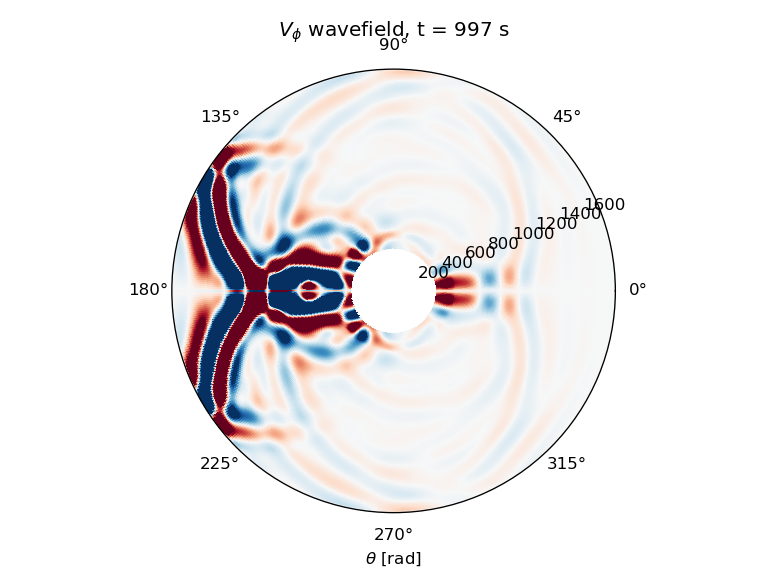

CPU times: user 4min 33s, sys: 1.66 s, total: 4min 34s
Wall time: 1min 10s


In [11]:
# Run SH FD modelling for modified Weber etal. (2011) moon model
# --------------------------------------------------------------
%matplotlib notebook

# Define source depth (m)
zsrc = 800.0 * 1000.0

# Interpolate 1D PREM model on FD grid
r    = np.arange(nr)                    # r-coordinates on FD grid
r    = rcore + r * dr                   # add core radius

# define interpolation function
rshift = 0  # shift 1D PREM model with respect to FD model

fvs = interpolate.interp1d(np.flipud(radius-rshift),np.flipud(vs1D),kind="nearest")
vs1D_fd = fvs(r)

frho = interpolate.interp1d(np.flipud(radius-rshift),np.flipud(rho1D),kind="nearest")
rho1D_fd = fvs(r)

# build 2D vs and density PREM models
vs1Dmoon = np.tile(vs1D_fd, (ntheta,1))
rho1Dmoon = np.tile(rho1D_fd, (ntheta,1))

# define wavefield clip value    
clip = 3e-11

# calculate time step according to CFL criterion
dt = dr / (np.sqrt(2) * np.max(vs1Dmoon)) 

%time time_moon, seis_moon = FD_2D_SH_JIT(dt,dr,dtheta,f0,vs1Dmoon,rho1Dmoon,nr,ntheta,clip,zsrc)

Compared to the [1D PREM earth modelling results](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/07_SH_waves_in_moons_and_planets/2_2D_SHaxi_FD_modelling_earth.ipynb) you may notice the domainant Love waves propagating in the partially melted layer above the outer fluid lunar core, which continously radiate SH body waves. Let's take a look at the seismic section recorded at each $\theta$-gridpoint on the lunar surface:

<IPython.core.display.Javascript object>


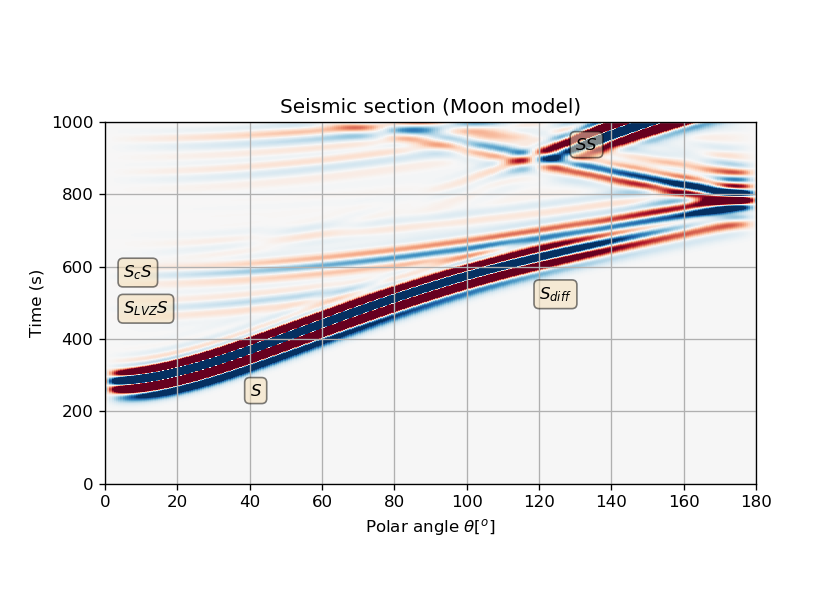

In [12]:
# Plot PREM FD seismograms at polar angles between 0 and 180°
# -----------------------------------------------------------
%matplotlib notebook

# Define figure size
rcParams['figure.figsize'] = 7, 5

extent = [0,180.0,tmax,0]
clip = 5e-12
plt.imshow(seis_moon.T, extent=extent, cmap="RdBu",vmin=-clip,vmax=clip, aspect=1e-1)

# annotate major wave phases
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(40, 280, r"$S$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(5, 510, r"$S_{LVZ}S$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(5, 610, r"$S_cS$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(120, 550, r"$S_{diff}$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(130, 960, r"$SS$", fontsize=10, verticalalignment='top', bbox=props)

plt.title(r'Seismic section (Moon model)')
plt.xlabel(r'Polar angle $\theta [^o]$')
plt.ylabel('Time (s)')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

In the seismic section, we can clearly identify the direct S wave and diffracted outer core phase $S_{diff}$, as well as the (multiple) reflections from the low-velocity layer   above the outer core $S_{LVZ}S$, core reflection $S_cS$ and lunar surface reflection $SS$.

Keep in mind, that the sparse Apollo seismic network could only record 4 seismograms per event, so a typical record looks like this:

<IPython.core.display.Javascript object>


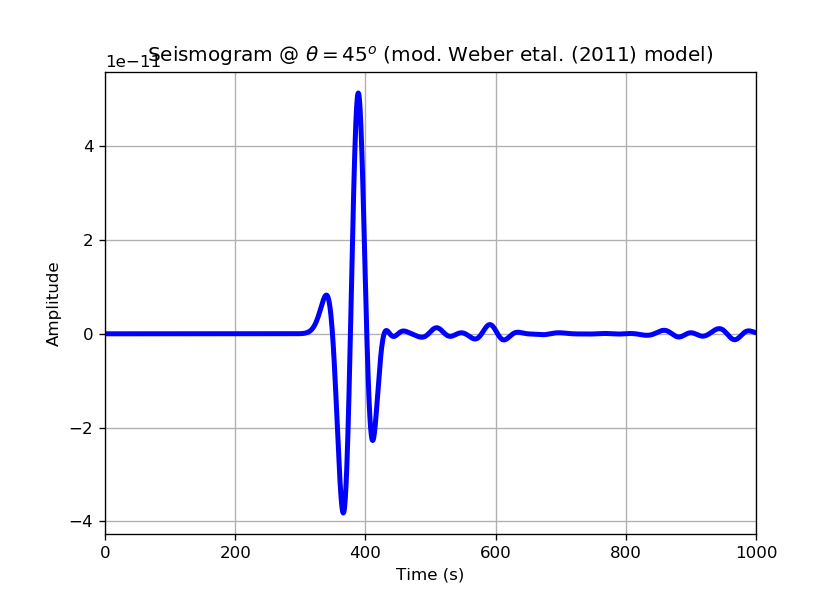

In [13]:
# Plot FD seismogram at polar angle 45°
# -------------------------------------
%matplotlib notebook
# Define figure size
rcParams['figure.figsize'] = 7, 5
plt.plot(time_moon, seis_moon[(int)(ntheta/4),:], 'b-',lw=3,label="FD solution") # plot FD seismogram
plt.xlim(time_moon[0], time_moon[-1])
plt.title(r'Seismogram @ $\theta = 45^o$ (mod. Weber etal. (2011) model)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

Based on the seismogram record above, you might think that it is quite easy to derive the internal structure of the moon based on the distinct core reflections, even with this coarse network coverage. However, there is an additional problem, which we neglected so far ...

## SH-wave scattering by the megaregolith crust

Due to the constant bomardement of the moon by meteoroids, asteroids and comets during it's history, the lunar crust is significantly fissured, leading to signicant scattering of the seismic wavefield. To incorporate this effect into our FD modelling, we replace the homogeneous lunar crust by a random medium. 

<IPython.core.display.Javascript object>


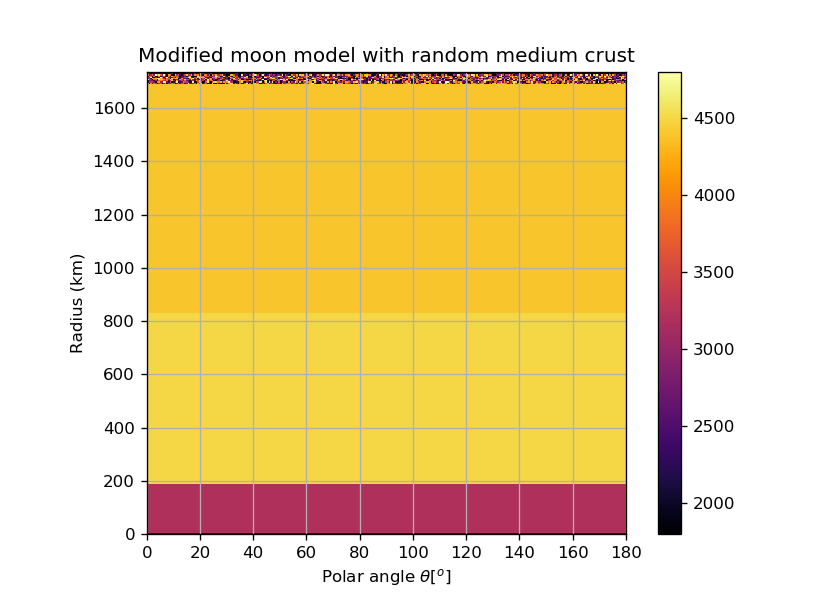

In [14]:
# Superimpose random medium on lunar crust 
# ----------------------------------------
%matplotlib notebook

# build 2D vs and density PREM models
vs1Dmoon = np.tile(vs1D_fd, (ntheta,1))
rho1Dmoon = np.tile(rho1D_fd, (ntheta,1))

pert = 0.5  # perturbation of crustal material parameters
# create random perturbations for the whole model
r = 2.0 * (np.random.rand(ntheta, nr) - 0.5) * pert 

# calculate lunar crust thickness (gridpoints)
d_crust = 39.0 * 1000         # crustal thickness (m)
nd_crust = (int)(d_crust/dr)  # crustal thickness (gridpoints)

# add perturbation to lunar crust
vs_moon_rand = vs1Dmoon
rho_moon_rand = rho1Dmoon

vs_moon_rand[:,nr-nd_crust:nr] = vs1Dmoon[:,nr-nd_crust:nr] * (1 + r[:,nr-nd_crust:nr])                  
rho_moon_rand[:,nr-nd_crust:nr] = rho1Dmoon[:,nr-nd_crust:nr] * (1 + r[:,nr-nd_crust:nr])                  
        
# Define figure size
rcParams['figure.figsize'] = 7, 5

extent = [0,180.0,rplanet/1000,0]
plt.imshow(vs_moon_rand.T, extent=extent, cmap="inferno", aspect=1e-1,vmin=1800)

plt.title(r'Modified moon model with random medium crust')
plt.xlabel(r'Polar angle $\theta [^o]$')
plt.ylabel('Radius (km)')
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.show()

Let's see how the random medium perturbations in the lunar crust affect the recorded seismic SH-wavefield.

nt =  1930


<IPython.core.display.Javascript object>


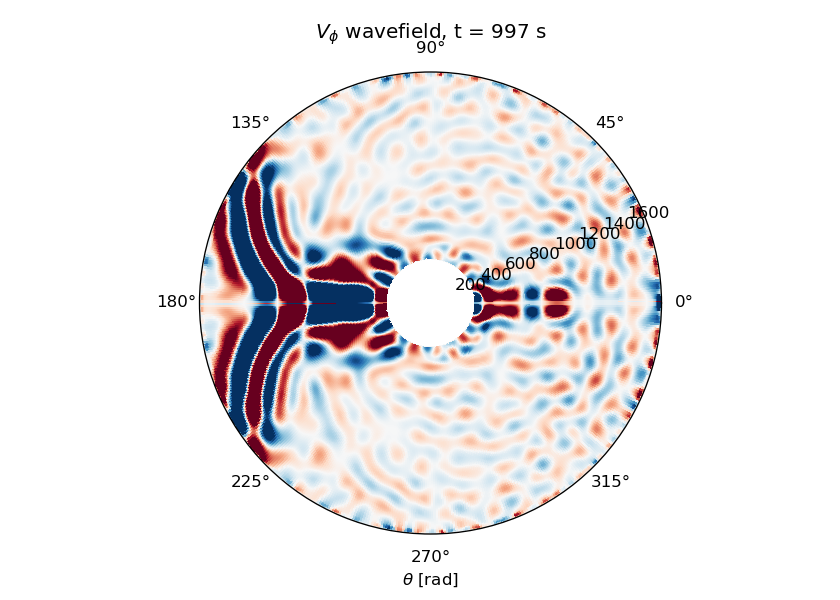

CPU times: user 4min 59s, sys: 1.91 s, total: 5min 1s
Wall time: 1min 17s


In [15]:
# Run SH FD modelling for modified Weber etal. (2011) moon model 
# with random medium crust
# --------------------------------------------------------------
%matplotlib notebook

# Define source depth (m)
zsrc = 800.0 * 1000.0

# define wavefield clip value    
clip = 3e-11

# calculate time step according to CFL criterion
dt = dr / (np.sqrt(2) * np.max(vs1Dmoon)) 

%time time_moon_rand, seis_moon_rand = FD_2D_SH_JIT(dt,dr,dtheta,f0,vs_moon_rand,rho_moon_rand,nr,ntheta,clip,zsrc)

Even though we use an unrealistic low centre frequency for the source wavelet, the SH wavefield is significantly scattered by the random medium lunar crust. Let's take a look at the seismic section for receivers placed at each gridpoint in $\theta$-direction at the lunar surface:

<IPython.core.display.Javascript object>


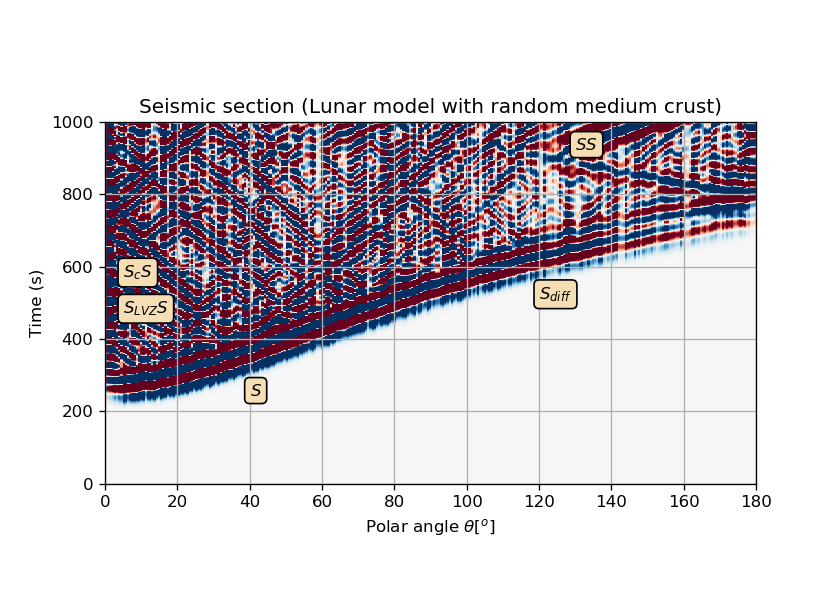

In [16]:
# Plot FD seismograms for random medium lunar crust at polar angles 
# between 0 and 180°
# -----------------------------------------------------------------
%matplotlib notebook

# Define figure size
rcParams['figure.figsize'] = 7, 5

extent = [0,180.0,tmax,0]
clip = 3e-12
plt.imshow(seis_moon_rand.T, extent=extent, cmap="RdBu",vmin=-clip,vmax=clip, aspect=1e-1)

# annotate major wave phases
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat')
plt.text(40, 280, r"$S$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(5, 510, r"$S_{LVZ}S$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(5, 610, r"$S_cS$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(120, 550, r"$S_{diff}$", fontsize=10, verticalalignment='top', bbox=props)
plt.text(130, 960, r"$SS$", fontsize=10, verticalalignment='top', bbox=props)
# place a text box in upper left in axes coords
#plt.text(40, 310, r"$S$", fontsize=10, verticalalignment='top', bbox=props)
#plt.text(120, 700, r"$S_{diff}$", fontsize=10, verticalalignment='top', bbox=props)
#plt.text(50, 800, "Love", fontsize=10, verticalalignment='top', bbox=props)

plt.title(r'Seismic section (Lunar model with random medium crust)')
plt.xlabel(r'Polar angle $\theta [^o]$')
plt.ylabel('Time (s)')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

In the seismic section, I copied the annotations from the modelling result for the homogeneous lunar crust. The only distinct phases are $S$, $S_{diff}$ and $SS$. The weak LVZ and core reflections are hidden in the scattered crustal wavefield. If we have to rely only on 4 seismograms like this:

<IPython.core.display.Javascript object>


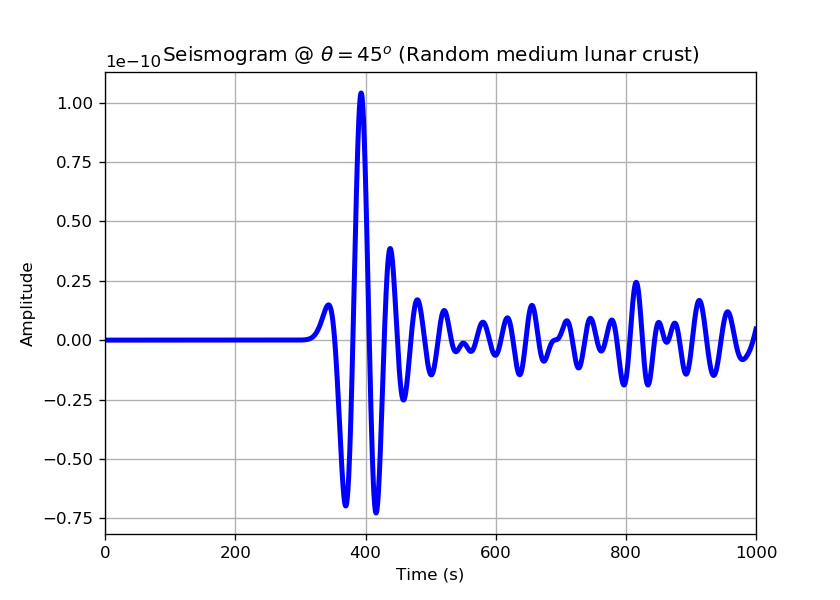

In [17]:
# Plot FD seismogram at polar angle 45°
# -------------------------------------
%matplotlib notebook
# Define figure size
rcParams['figure.figsize'] = 7, 5
plt.plot(time_moon_rand, seis_moon_rand[(int)(ntheta/4),:], 'b-',lw=3,label="FD solution") # plot FD seismogram
plt.xlim(time_moon_rand[0], time_moon_rand[-1])
plt.title(r'Seismogram @ $\theta = 45^o$ (Random medium lunar crust)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

we can understand why it is quite challenging to derive the internal lunar structure from the deep moonquakes.

##### Exercise

Model the axisymmetric SH wave propagation for a shallow moonquake in 60 km depth using the elastic lunar model with random perturbations in the crust. Compare and discuss the seismic section for receivers placed at every $\theta$ gridpoint and single station recording at $\theta=45^o$ with the seismograms of the deep moonquake. Identify the visible phases.

## What we learned:

* Seismometers placed on the lunar surface during the Apollo missions lead to the discovery of shallow, deep, thermal- and impact-induced moonquakes
* Based on axisymmetric SH modelling results of deep moonquakes for the elastic lunar model derived by Weber et al. (2011), it should be quite easy to derive the internal moon structure ...
* ... however, the fissured lunar crust significantly scatters the SH wavefield, hiding the important reflected core phases
* We need a new dense, modern seismometer network on the moon